# Importing Necessary Libraries

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

# Load the data

In [6]:
# Load the data
data = pd.read_csv('BrentOilPrices.csv')
data.head()

,Date,Price
0,20-May-87,18.63
1,21-May-87,18.45
2,22-May-87,18.55
3,25-May-87,18.60
4,26-May-87,18.63


In [21]:
gdp_data = pd.read_csv('Countries GDP 1960-2020.csv')
gdp_data.head()

,Country Name,Country Code,1960,1961,1962,1963,1964,1965,1966,1967,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Africa Eastern and Southern,AFE,1.931311e+10,1.972349e+10,2.149392e+10,2.573321e+10,2.352744e+10,2.681057e+10,2.915216e+10,3.017317e+10,...,9.430000e+11,9.510000e+11,9.640000e+11,9.850000e+11,9.200000e+11,8.730000e+11,9.850000e+11,1.010000e+12,1.010000e+12,9.210000e+11
1,Africa Western and Central,AFW,1.040428e+10,1.112805e+10,1.194335e+10,1.267652e+10,1.383858e+10,1.486247e+10,1.583285e+10,1.442643e+10,...,6.710000e+11,7.280000e+11,8.210000e+11,8.650000e+11,7.610000e+11,6.910000e+11,6.840000e+11,7.420000e+11,7.950000e+11,7.850000e+11
2,Australia,AUS,1.860679e+10,1.968306e+10,1.992272e+10,2.153993e+10,2.380110e+10,2.597715e+10,2.730989e+10,3.044462e+10,...,1.400000e+12,1.550000e+12,1.580000e+12,1.470000e+12,1.350000e+12,1.210000e+12,1.330000e+12,1.430000e+12,1.390000e+12,1.330000e+12
3,Austria,AUT,6.592694e+09,7.311750e+09,7.756110e+09,8.374175e+09,9.169984e+09,9.994071e+09,1.088768e+10,1.157943e+10,...,4.310000e+11,4.090000e+11,4.300000e+11,4.420000e+11,3.820000e+11,3.960000e+11,4.160000e+11,4.550000e+11,4.450000e+11,4.330000e+11
4,Burundi,BDI,1.960000e+08,2.030000e+08,2.135000e+08,2.327500e+08,2.607500e+08,1.589950e+08,1.654446e+08,1.782971e+08,...,2.235821e+09,2.333308e+09,2.451625e+09,2.705783e+09,3.104395e+09,2.732809e+09,2.748180e+09,2.668496e+09,2.631434e+09,2.841786e+09


# EDA

In [7]:
# Convert Date column to datetime format with flexible parsing
data['Date'] = pd.to_datetime(data['Date'], infer_datetime_format=True, errors='coerce')

# Drop rows with unparseable dates
data.dropna(subset=['Date'], inplace=True)

# Set the Date column as the index
data.set_index('Date', inplace=True)

# Display the first few rows of the dataset
data.head()

,Price
Date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63


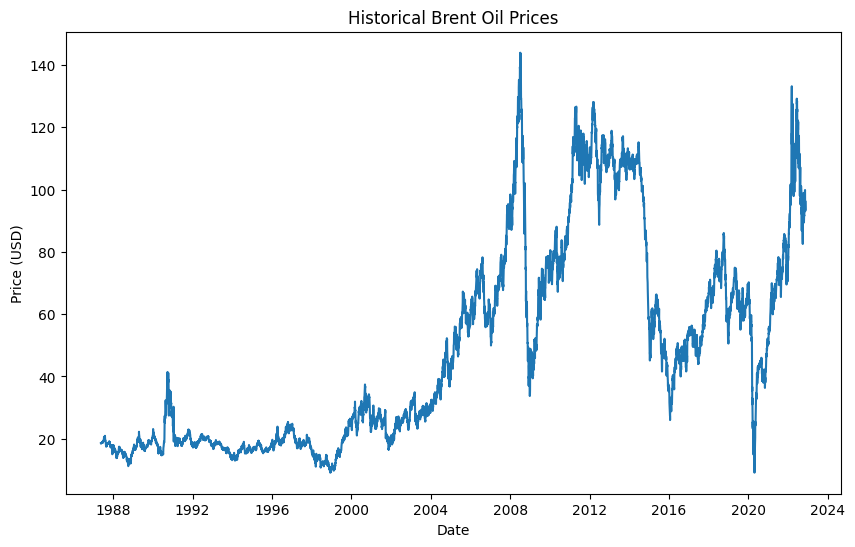

In [8]:
# Plotting the Time Series
plt.figure(figsize=(10, 6))
plt.plot(data['Price'])
plt.title('Historical Brent Oil Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.show()

In [9]:
data.describe()

,Price
count,9011.000000
mean,48.420782
std,32.860110
min,9.100000
25%,19.050000
50%,38.570000
75%,70.090000
max,143.950000


In [22]:
def analyze_brent_oil_price_distribution(df):
    """
    Analyzes the distribution of Brent oil prices using a histogram and a density plot.

    Parameters:
    brent_oil_df (pandas.DataFrame): A DataFrame containing the Brent oil price data, with the 'Price' column.

    Returns:
    None
    """


    # Set general aesthetics for the plots
    sns.set_style("whitegrid")
    # Create a histogram
    plt.figure(figsize=(10, 6))
    df['Price'].hist(bins=30)
    plt.title('Histogram of Brent Oil Prices')
    plt.xlabel('Price (USD/barrel)')
    plt.ylabel('Frequency')
    plt.show()

    # Create a density plot
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=df, x='Price', shade=True)
    plt.title('Density Plot of Brent Oil Prices')
    plt.xlabel('Price (USD/barrel)')
    plt.ylabel('Density')
    plt.show()

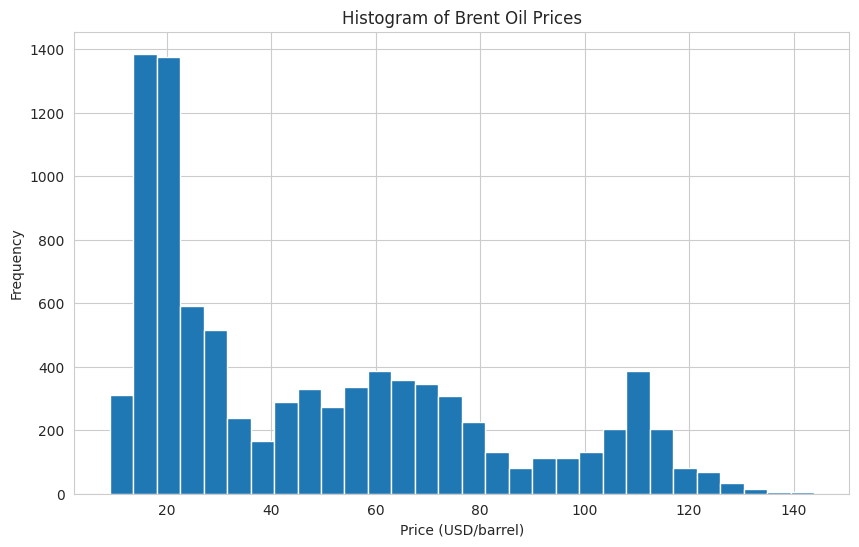

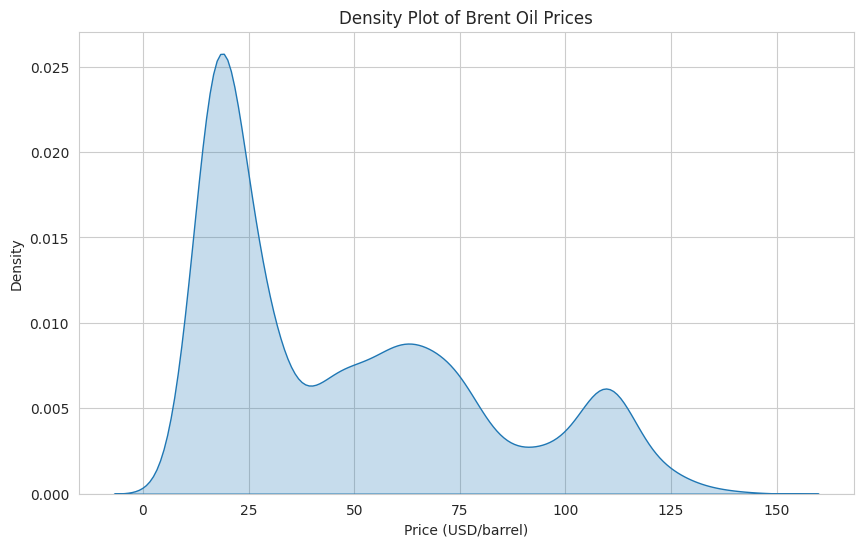

In [23]:
analyze_brent_oil_price_distribution(data)

In [24]:
def check_stationarity(brent_oil_df):
    """
    Checks if the Brent oil price time series is stationary using the Augmented Dickey-Fuller (ADF) test.
    If the series is non-stationary, determines the appropriate level of differencing required to achieve stationarity.

    Parameters:
    brent_oil_df (pandas.DataFrame): A DataFrame containing the Brent oil price data, with the 'Price' column.

    Returns:
    int: The level of differencing required to achieve stationarity (0 if the series is already stationary).
    """
    # Perform the Augmented Dickey-Fuller test
    result = adfuller(brent_oil_df['Price'])

    # Check if the series is stationary
    if result[1] > 0.05:
        print("The Brent oil price time series is non-stationary.")

        # Determine the appropriate level of differencing
        diff_level = 1
        while True:
            brent_oil_diff = brent_oil_df['Price'].diff(periods=diff_level).dropna()
            result = adfuller(brent_oil_diff)
            if result[1] <= 0.05:
                print(f"The Brent oil price time series becomes stationary after {diff_level} level(s) of differencing.")
                return diff_level
            diff_level += 1
    else:
        print("The Brent oil price time series is stationary.")
        return 0

In [26]:
# Checking for Stationarity
diff_level = check_stationarity(data)
diff_level

The Brent oil price time series is non-stationary.
The Brent oil price time series becomes stationary after 1 level(s) of differencing.


1

In [30]:
def visualize_acf_pacf(brent_oil_df, diff_level=1):
    """
    Visualizes the autocorrelation function (ACF) and partial autocorrelation function (PACF) plots for the Brent oil price time series.

    Parameters:
    brent_oil_df (pandas.DataFrame): A DataFrame containing the Brent oil price data, with the 'Price' column.
    diff_level (int): The level of differencing required to achieve stationarity (default is 0).

    Returns:
    None
    """
        # Set general aesthetics for the plots
    sns.set_style("whitegrid")

    if diff_level > 0:
        brent_oil_diff = brent_oil_df['Price'].diff(periods=diff_level).dropna()
    else:
        brent_oil_diff = brent_oil_df['Price']

    # Plot the ACF
    plt.figure(figsize=(10, 6))
    plot_acf(brent_oil_diff, lags=20)
    plt.title('Autocorrelation Function (ACF) of Brent Oil Prices')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.show()

    # Plot the PACF
    plt.figure(figsize=(10, 6))
    plot_pacf(brent_oil_diff, lags=20)
    plt.title('Partial Autocorrelation Function (PACF) of Brent Oil Prices')
    plt.xlabel('Lag')
    plt.ylabel('Partial Autocorrelation')
    plt.show()


<Figure size 1000x600 with 0 Axes>

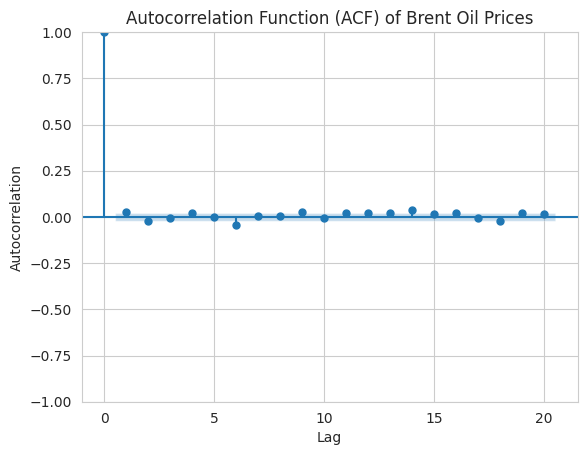

<Figure size 1000x600 with 0 Axes>

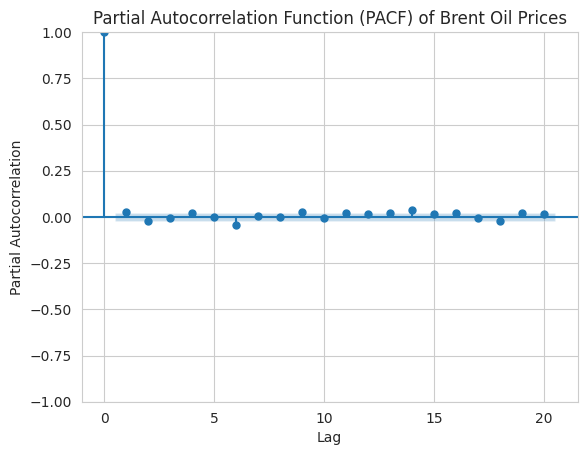

In [32]:
visualize_acf_pacf(data, diff_level)

In [15]:
# Checking for Stationarity
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')

# Perform the ADF test
adf_test(data['Price'])


ADF Statistic: -1.9938560113924675
p-value: 0.28927350489340287
Critial Values:
   1%, -3.4310783342658615
Critial Values:
   5%, -2.861861876398633
Critial Values:
   10%, -2.566941329781918


In [11]:
data['Price_diff'] = data['Price'].diff().dropna()

# Re-check stationarity
adf_test(data['Price_diff'].dropna())

ADF Statistic: -15.52936758004802
p-value: 2.230740510516298e-28
Critial Values:
   1%, -3.4310783342658615
Critial Values:
   5%, -2.861861876398633
Critial Values:
   10%, -2.566941329781918


In [13]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.5 MB/s eta 0:00:00


In [14]:
#Making the Time Series Stationary
from pmdarima import auto_arima

# Finding the best ARIMA parameters
auto_arima_model = auto_arima(data['Price'], seasonal=False, trace=True)
auto_arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=29077.401, Time=29.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=29099.750, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=29096.009, Time=0.72 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=29095.724, Time=1.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=29098.172, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=29094.808, Time=6.52 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=29094.590, Time=4.20 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=37.97 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=31.22 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=29095.495, Time=2.19 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=29095.647, Time=9.32 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=29095.657, Time=11.08 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=29079.401, Time=20.51 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=29075.828, Time=5.70 sec
 ARIMA(1,1,2)(0,0,0)[0]   

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 9011
Model:               SARIMAX(3, 1, 2)   Log Likelihood              -14528.469
Date:                Wed, 10 Jul 2024   AIC                          29068.939
Time:                        04:59:35   BIC                          29111.575
Sample:                             0   HQIC                         29083.446
                               - 9011                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0194      0.008      2.446      0.014       0.004       0.035
ar.L2         -0.9860      0.005   -201.353      0.000      -0.996      -0.976
ar.L3          0.0033      0.006      0.540      0.589      -0.009       0.015
ma.L1         -0.0230      0.006     -3.723      0.000      -0.035      -0.011
ma.L2          0.9790      0.006    164.645      0.000       0.967       0.991
sigma2         1.4791      0.008    176.201      0.000       1.463       1.496
===================================================================================
Ljung-Box (L1) (Q):                   7.69   Jarque-Bera (JB):             64719.62
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):              10.96   Skew:                            -0.65
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

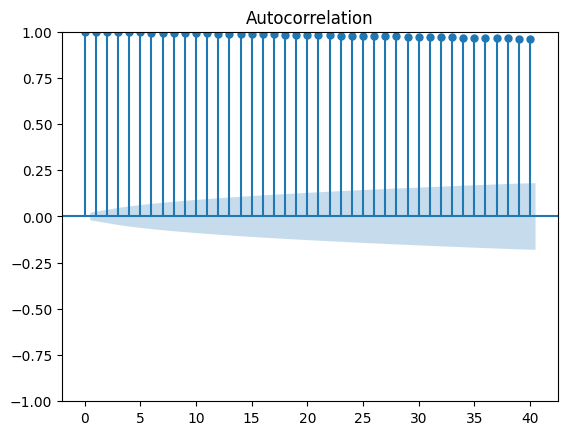

In [19]:
from statsmodels.graphics.tsaplots import plot_acf

# Plotting the ACF
plot_acf(data['Price'])
plt.show()

In [20]:
# Extract the optimal parameters
# p, d, q = auto_arima_model.order

# Fit the ARIMA model with the optimal parameters
model = ARIMA(data['Price'], order=(5, 1, 0))
fit_model = model.fit()

# Summary of the model
fit_model.summary()

NotImplementedError: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.
